<a href="https://colab.research.google.com/github/JhulianaM/Mammography/blob/master/CompEdsrTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Paso 1: Subir el archivo kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhulianamercado","key":"a71185f6733aa19acf1b25c0137bd4ea"}'}

In [2]:
# Paso 2: Configurar Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Paso 3: Descargar el Dataset de Kaggle
!kaggle datasets download -d kmader/mias-mammography
!unzip mias-mammography.zip -d mias-mammography

Dataset URL: https://www.kaggle.com/datasets/kmader/mias-mammography
License(s): other
 99% 308M/312M [00:11<00:00, 33.0MB/s]
100% 312M/312M [00:11<00:00, 29.1MB/s]
Archive:  mias-mammography.zip
  inflating: mias-mammography/Info.txt  
  inflating: mias-mammography/all-mias.tar.gz  
  inflating: mias-mammography/all-mias/Info.txt  
  inflating: mias-mammography/all-mias/Licence.txt  
  inflating: mias-mammography/all-mias/README  
  inflating: mias-mammography/all-mias/mdb001.pgm  
  inflating: mias-mammography/all-mias/mdb002.pgm  
  inflating: mias-mammography/all-mias/mdb003.pgm  
  inflating: mias-mammography/all-mias/mdb004.pgm  
  inflating: mias-mammography/all-mias/mdb005.pgm  
  inflating: mias-mammography/all-mias/mdb006.pgm  
  inflating: mias-mammography/all-mias/mdb007.pgm  
  inflating: mias-mammography/all-mias/mdb008.pgm  
  inflating: mias-mammography/all-mias/mdb009.pgm  
  inflating: mias-mammography/all-mias/mdb010.pgm  
  inflating: mias-mammography/all-mias/mdb01

In [15]:
import cv2
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [6]:
# Preprocesamiento de las imágenes
def load_images(path, img_size=(256, 256)):
    images = []
    for img_path in glob.glob(path + '/*.pgm'):
        img = load_img(img_path, color_mode='grayscale', target_size=img_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalizar
        images.append(img)
    return np.array(images)

# Cargar las imágenes
#images_path = './all-mias'
images_path = './mias-mammography/all-mias'
images = load_images(images_path)

#print(f"Total images loaded: {len(images)}")
#print(f"Shape of first image: {images[0].shape}")

# Crear imágenes de baja resolución
def create_low_res_images(images, scale=2):
    low_res_images = []
    for img in images:
        low_res_img = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_AREA)
        low_res_img = cv2.resize(low_res_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
        low_res_images.append(low_res_img)
    return np.array(low_res_images)

low_res_images = create_low_res_images(images)

# Expandiendo las dimensiones para tener la forma (num_images, height, width, channels)
x_train, x_test, y_train, y_test = train_test_split(low_res_images, images, test_size=0.2, random_state=42)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Asegurarse de que las formas sean correctas para y_train y y_test
y_train = np.expand_dims(y_train, axis=-1).squeeze(axis=-1)
y_test = np.expand_dims(y_test, axis=-1).squeeze(axis=-1)

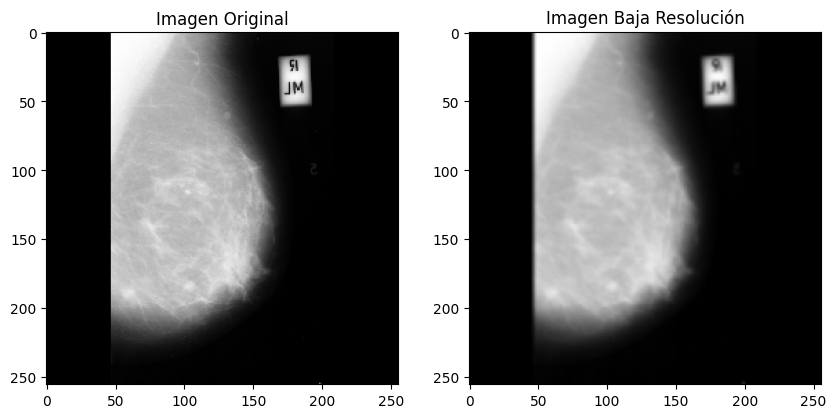

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(images[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Imagen Baja Resolución")
plt.imshow(low_res_images[0], cmap='gray')
plt.show()

In [7]:
# Verificar las formas
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (257, 256, 256, 1)
x_test shape: (65, 256, 256, 1)
y_train shape: (257, 256, 256, 1)
y_test shape: (65, 256, 256, 1)


In [8]:
pip install tensorflow-hub

In [11]:
# Definir una capa personalizada para el modelo preentrenado
class EDSRLayer(tf.keras.layers.Layer):
    def __init__(self, model_url, **kwargs):
        super(EDSRLayer, self).__init__(**kwargs)
        self.model = hub.KerasLayer(model_url)

    def call(self, inputs):
        # Asegurarse de que los inputs tengan 3 canales (el modelo de hub puede esperar una entrada RGB)
        inputs_rgb = tf.image.grayscale_to_rgb(inputs)
        return self.model(inputs_rgb)

In [13]:
# Cargar el modelo EDSR preentrenado de TensorFlow Hub
model_url = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [26]:
from tensorflow.keras.layers import UpSampling2D, Conv2D


In [31]:
# Crear un nuevo modelo que incluye el modelo preentrenado
input_layer = tf.keras.layers.Input(shape=(256, 256, 1))
x = EDSRLayer(model_url)(input_layer)

# Capas adicionales de convolución para mantener el tamaño de la imagen
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Asegurarse de que el padding sea 'same'
x = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Última capa para mantener la resolución original
# Redimensionar la salida a 256x256
output_layer = tf.keras.layers.Resizing(256, 256, interpolation='bilinear')(x)



model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 edsr_layer_10 (EDSRLayer)   (None, 1024, 1024, 3)     4605955   
                                                                 
 conv2d_12 (Conv2D)          (None, 1024, 1024, 64)    1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 1024, 1024, 1)     577       
                                                                 
 resizing_2 (Resizing)       (None, 256, 256, 1)       0         
                                                                 
Total params: 4608324 (17.58 MB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 4605955 (17.57 MB)
_________________________________________________________________


In [17]:
# Verificar formas del modelo
print(f"Input shape: {input_layer.shape}")
print(f"Output shape: {model.output.shape}")

Input shape: (None, 256, 256, 1)
Output shape: (None, 256, 256, 1)


In [18]:
# Callbacks para el entrenamiento
checkpoint = ModelCheckpoint('edsr_finetuned.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [19]:
# Generador de datos con augmentación
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [20]:
# Ajuste del generador a los datos de entrenamiento
datagen.fit(x_train)

In [21]:
# Verificación de formas en la primera batch del generador de datos
x_batch, y_batch = next(datagen.flow(x_train, y_train, batch_size=16))
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

x_batch shape: (16, 256, 256, 1)
y_batch shape: (16, 256, 256, 1)


In [32]:
# Entrenamiento del modelo con el generador de datos
history = model.fit(datagen.flow(x_train, y_train, batch_size=4),
                    validation_data=(x_test, y_test),
                    epochs=50,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.4548

ResourceExhaustedError: Graph execution error:

Detected at node conv2d_transpose defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[32,32,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_287144]